In [1]:
# using Pkg
# Pkg.add("Plots")
# Pkg.add("Symbolics")
# Pkg.add("DataFrames")
#using Symbolics
#using DataFrames
using Plots

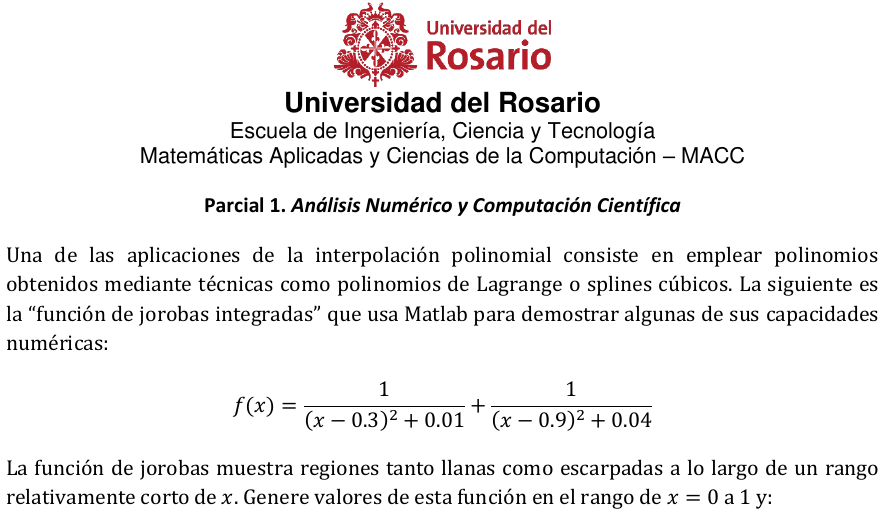

**Solución por: David Santiago Florez Alsina**

In [2]:
function jorobas(x::Float64)::Float64
    return 1.0/(((x - 0.3)^2) + 0.01) + 1.0/(((x - 0.9)^2) + 0.04)
end

jorobas (generic function with 1 method)

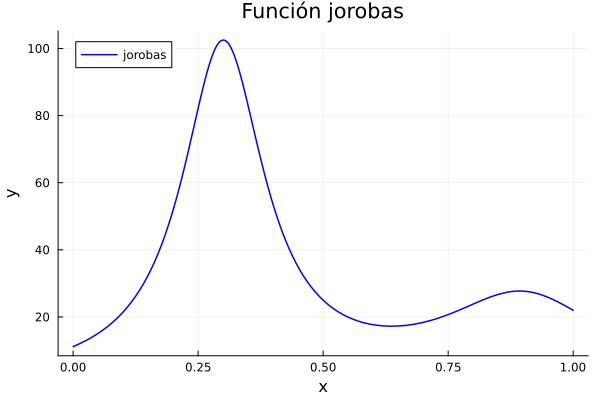

In [3]:
plot(jorobas, 0, 1,
     label="jorobas",
     title="Función jorobas",
     xlabel="x", ylabel="y", linewidth=1.5, linecolor=:blue, legend=:topleft)

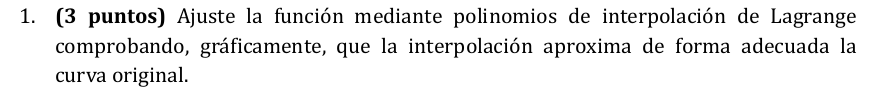

In [4]:

function lagrange_coefficients(xvalue::Float64, x::Vector, k::Int)::Float64

    """
        Calculates the lagrange coefficients for the lagrange polynomial interpolation.

        Parameters
        ----------
            xvalue: point to interpolate.
            x: list of points [x, y] to interpolate.
            k: index of the point to interpolate.
        
        Returns
        -------
            y: interpolated value.
    """

    n = length(x)
    numerator = 1
    denominator = 1

    for j = 1:n
        if j != k
            numerator = numerator * (xvalue - x[j])
            denominator = denominator * (x[k] - x[j])
        end
    end

    return numerator / denominator
end

function lagrange_polynomial(points::Vector{Vector{Float64}}, x::Float64)
    """
        Polynomial Interpolation, with lagrange polynomials.

        Parameters
        ----------
            points: list of points [x, y] to interpolate.
            x: point to interpolate.
        
        Returns
        -------
            y: interpolated value.
    """

    y = 0.0
    xpoints = [points[i][1] for i in 1:length(points)]
    ypoints = [points[i][2] for i in 1:length(points)]

    for k in 1:length(points)
        pointx = xpoints[k]
        pointy = ypoints[k]

        y += pointy * lagrange_coefficients(x, xpoints, k)
    end

    return y 
end

lagrange_polynomial (generic function with 1 method)

Para interpolar esto con lagrange probaré inicialmente con un tamaño de espacio entre muestra de 0.1 en el rango 0 a 1.

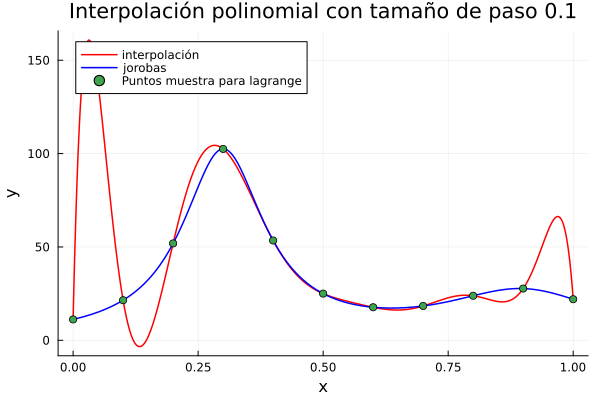

In [5]:
#domain 
stepsize = 0.1
sample_domain = 0:stepsize:1

#build the set of points 
points = [[x, jorobas(x)] for x in sample_domain]

#get the values from the lagrange polynomial
high_resolution_domain = 0:0.001:1
ysampled = [lagrange_polynomial(points, x) for x in high_resolution_domain]


plot(high_resolution_domain, ysampled, title = "Interpolación polinomial con tamaño de paso $(stepsize)", label="interpolación", linewidth=1.5, linecolor=:red, legend=:topleft)
plot!(jorobas, 0, 1,
     label="jorobas",
     xlabel="x", ylabel="y", linewidth=1.5, linecolor=:blue, legend=:topleft)
scatter!([point[1] for point in points], [point[2] for point in points], label="Puntos muestra para lagrange")

Como se puede ver con un tamaño de paso pequeño no se ve tan bien, pero aumentandole la resolución del muestreo lo logramos, sin embargo cabe notar que cerca a los extremos el comportamiento es muy similar en los puntos que se evalúan pero se empiezan a tener curvas fuertes:

Primero veremos el caso normal (quitando los extremos donde se comporta muy bruscamente es decir desde 0 a 0.1, dando pasos de 0.001, y quitando desde 0.9 a 1 con pasos de 0.001), esto para poder ver desde cerca el comportamiento sin perder detalle por estas subidas bruscas.

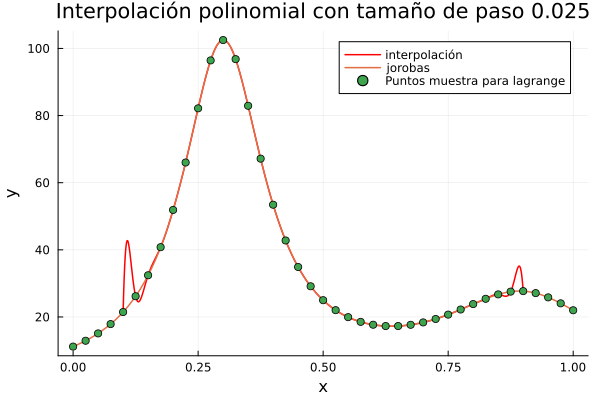

In [6]:
#domain 
stepsize = 0.025
sample_domain = 0:stepsize:1

#build the set of points 
points = [[x, jorobas(x)] for x in sample_domain]

#get the values from the lagrange polynomial
high_resolution_domain = 0.1:0.001:0.9
ysampled = [lagrange_polynomial(points, x) for x in high_resolution_domain]


plot(high_resolution_domain,
     ysampled,
     title = "Interpolación polinomial con tamaño de paso $(stepsize)",
     label="interpolación",
     linewidth=1.5,
     linecolor=:red,)

plot!(jorobas, 0, 1,
      label="jorobas",
      xlabel="x",
      ylabel="y",
      linewidth=1.5,)

scatter!([point[1] for point in points],
         [point[2] for point in points],
         label="Puntos muestra para lagrange")

Ahora lo veremos completo sin quitar el intervalo 0 a 0.1 y 0.9 a 1

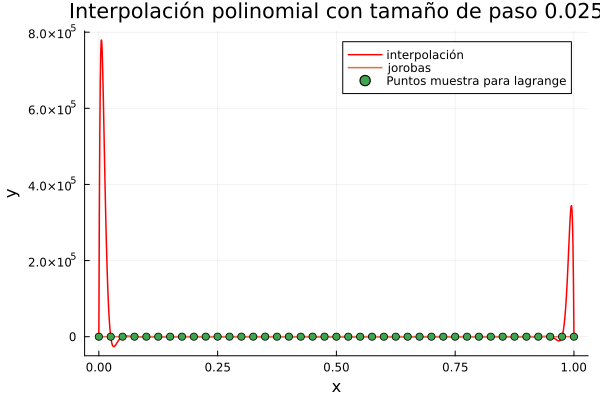

In [7]:
#domain 
stepsize = 0.025
sample_domain = 0:stepsize:1

#build the set of points 
points = [[x, jorobas(x)] for x in sample_domain]

#get the values from the lagrange polynomial
high_resolution_domain = 0:0.001:1
ysampled = [lagrange_polynomial(points, x) for x in high_resolution_domain]


plot(high_resolution_domain,
     ysampled,
     title = "Interpolación polinomial con tamaño de paso $(stepsize)",
     label="interpolación",
     linewidth=1.5,
     linecolor=:red,)

plot!(jorobas, 0, 1,
      label="jorobas",
      xlabel="x",
      ylabel="y",
      linewidth=1.5,)

scatter!([point[1] for point in points],
         [point[2] for point in points],
         label="Puntos muestra para lagrange")

Con una resolución de muestreo aún más baja la calidad del ajuste entre ambas funcones 

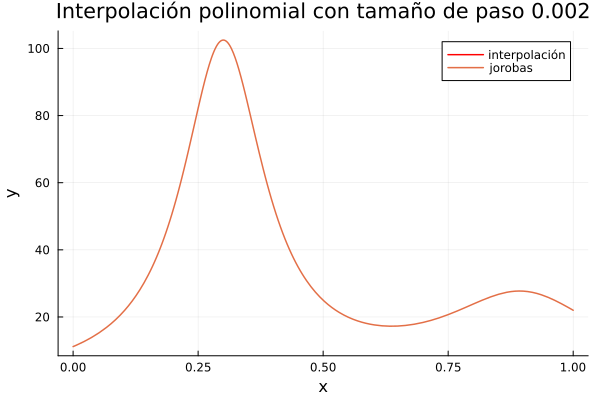

In [8]:
#domain 
stepsize = 0.002
sample_domain = 0:stepsize:1

#build the set of points 
points = [[x, jorobas(x)] for x in sample_domain]

#get the values from the lagrange polynomial
high_resolution_domain = 0:0.001:1
ysampled = [lagrange_polynomial(points, x) for x in high_resolution_domain]


plot(high_resolution_domain,
     ysampled,
     title = "Interpolación polinomial con tamaño de paso $(stepsize)",
     label="interpolación",
     linewidth=1.5,
     linecolor=:red,)

plot!(jorobas, 0, 1,
      label="jorobas",
      xlabel="x",
      ylabel="y",
      linewidth=1.5,)

#scatter!([point[1] for point in points],
         #[point[2] for point in points],
         #label="Puntos muestra para lagrange")

Una mucho mejor aproximación que no aumenta tanto el costo computacional es hacer lo que en el punto 6 del taller, que es usar interpolaciones cúbicas de lagrange, algo así:

In [18]:
function divide_into_groups(x_values::Vector{Float64}, y_values::Vector{Float64})

    """
        Given a set of points, this function divides the points in three groups, the first group contains the first three points,
        the second group contains the points from the fourth to the last three points, and the third group contains the last three points.

        Arguments:
        ----------------
            x_values: Vector of x values of the points to be interpolated.
            y_values: Vector of y values of the points to be interpolated.
        
        Returns:
        ----------------
            left: Vector of points [x,y] to be interpolated.
            mid: Vector of points [x,y] to be interpolated.
            right: Vector of points [x,y] to be interpolated.
    """

    # condition (n -4) % 3 == 1  or len(x) != len(y) or len(x) < 5
    if (length(x_values) - 4) % 3 != 1 || length(x_values) != length(y_values) || length(x_values) < 5
        println("The number of points is not correct")
        return nothing
    end

    #ends polynomials
    left = [[x_values[i], y_values[i]] for i in 1:3]
    right = [[x_values[i], y_values[i]] for i in length(x_values)-2:length(x_values)]

    #middle polynomials, gives all the pairs of 3 points for cubic interpolation in the middle
    mid = [[ [x_values[j], y_values[j]] for j in i:i+3 ] for i in 3:3:length(x_values)-3]

    return left, mid, right
end

function find_polynomium(left::Vector{Vector{Float64}},
                         mid::Vector{Vector{Vector{Float64}}},
                         right::Vector{Vector{Float64}},
                         target::Float64, n::Int)


    """
        Given a set of points, this function finds the polynomium that interpolates the points where the target is located.

        Arguments:
        ----------------
            left: Vector of points [x,y] to be interpolated.
            mid: Vector of points [x,y] to be interpolated.
            right: Vector of points [x,y] to be interpolated.
            target: value to interpolate
        
        Returns:
        ----------------
            polynomium: Vector of polynomials for the cubic spline method.
    """

    xleft = [left[i][1] for i in 1:length(left)]
    xright = [right[i][1] for i in 1:length(right)]
    xmiddles = [[mid[i][j][1] for j in 1:length(mid[i])] for i in 1:length(mid)]

    #if the targetx is between some of the left ones then return left
    if  (target <= xleft[end]) && (target >= xleft[1])
        return left

    #if the targetx is between some of the right ones then return right
    elseif (target <= xright[end]) && (target >= xright[1])
        return right

    #otherwise check if the target is between some of the middle ones
    else 
        for i in 1:length(xmiddles)
            if (target <= xmiddles[i][end]) && (target >= xmiddles[i][1])
                return mid[i]
            end
        end
    end
end


function plot_polynomiun(x_values::Vector{Float64}, y_values::Vector{Float64}, step::Float64)

    """
        Given a set of points, this function plots the polynomium that interpolates the points.

        Arguments:
        ----------------
            x_values: Vector of x values of the points to be interpolated.
            y_values: Vector of y values of the points to be interpolated.
            step: step to plot the polynomials
        
        Returns:
        ----------------
            polynomials: Vector of polynomials for the cubic spline method.
    """
    
    n = length(x_values)
    start = x_values[1]
    stop = x_values[end]

    #divide the set of points into groups used for the cubic interpolation
    #or quadratic with lagrange polys
    left, mid, right = divide_into_groups(x_values, y_values)

    pts = [[x, lagrange_polynomial( find_polynomium(left,mid, right, x, n) , x)] for x = start:step:stop]

    x = [p[1] for p in pts]
    y = [p[2] for p in pts]

    # Graficar puntos utilizando scatter() 
    plot(x, y, legend=true, title="Gráfico de Puntos", xlabel="Eje X", ylabel="Eje Y")
    # Agregar puntos de construccion
    scatter!([i for i in x_values],[i for i in y_values], label="Puntos", color=:red)   
end

plot_polynomiun (generic function with 1 method)

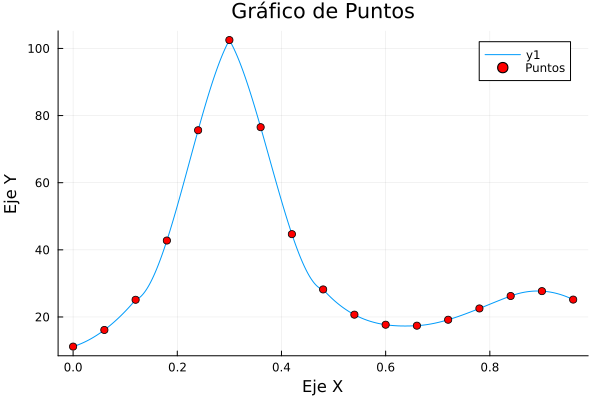

In [28]:
#domain 
stepsize = 0.06
sample_domain = 0:stepsize:1

#build the set of points 
points = [[x, jorobas(x)] for x in sample_domain]
x = [p[1] for p in points]
y = [p[2] for p in points]
plot_polynomiun(x, y, 0.001)

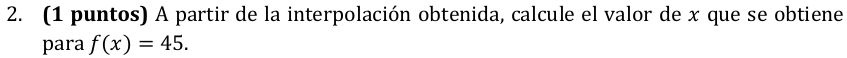

Para este caso usaremos a nuestro amigo fiel el secante:

In [11]:
function check_root_in_the_middle(f::Function, x0::Float64, x1::Float64)::Bool
    if f(x0) * f(x1) > 0
        return false
    else
        return true
    end
end

function find_segment_root(f::Function, x0::Float64, x1::Float64)::Float64
    """
        Finds the root of the segments that join (x0, f(x0)) and (x1, f(x1))
    """
    return x1 - f(x1) * (x1 - x0) / (f(x1) - f(x0))
end

function secant_method(f::Function,
                       x0::Float64,
                       x1::Float64,
                       tol::Float64,
                       maxiter::Int64,)
    """
        Finds the root of a function using the secant method.
        returns: the final [x0, x1] interval where the root is located.
    """
    
    if !check_root_in_the_middle(f, x0, x1)
        return x0, maxiter
    end

   for i in 1:maxiter
        x2 = find_segment_root(f, x0, x1)
        x0 = x1
        x1 = x2

        if abs(f(x1) - f(x0)) < tol
            return x1, i
        end
    end

    return x1, maxiter
end

secant_method (generic function with 1 method)

Hacemos nuestro muestreo de la función original, en este caso con un tamaño de paso de 0.015:

In [12]:
#domain 
stepsize = 0.015
sample_domain = 0:stepsize:1

#build the set of points 
points = [[x, jorobas(x)] for x in sample_domain]

#target value we want to get 
target = 45.0

#parameters for running the secant method
x0 = 0.1
x1 = 0.3
tol = 1e-10
max = 100


#we define our target function 
function f(x::Float64)::Float64
    return lagrange_polynomial(points, x) - target
end

result = secant_method(f, x0, x1, tol, max)
xroot_secant = result[1]
niters_secant = result[2]

println("Secante es un retrochimba y le tomó $(niters_secant) iteraciones converger.")
println("Encontró el valor $(target) (aprox.) para Jorobas, en f($(Float16(xroot_secant))), según la aproximación de lagrange")
println("El valor de jorobas en $(Float16(xroot_secant)) es $(jorobas(xroot_secant))")

Secante es un retrochimba y le tomó 22 iteraciones converger.
Encontró el valor 45.0 (aprox.) para Jorobas, en f(0.1853), según la aproximación de lagrange
El valor de jorobas en 0.1853 es 44.99986723811878


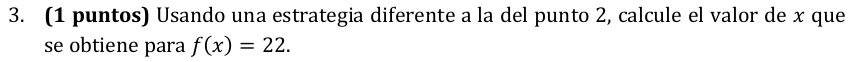

In [13]:
function error_metric(xaprox::Float64, xtarget::Float64, is_absolute::Bool)
    
    """
        This function calculates the error between the aproximation and the real value
        

        Parameters
        ----------
        xaprox: Float64, The aproximation of the of the function.
        xtarget: Float64, The real value we want.
        is_absolute: Bool, If true then the error is absolute, if false then the error is relative.

        Returns
        -------
        Float64, The error between the aproximation and the real value of the root of the function.
    """
    if is_absolute
        return abs(xtarget - xaprox) 
    else
        return abs(xtarget - xaprox)/xtarget
    end
end

function error_metric(xaprox::Float64, xtarget::Float64, is_absolute::Bool)
    
    """
        This function calculates the error between the aproximation and the real value
        

        Parameters
        ----------
        xaprox: Float64, The aproximation of the of the function.
        xtarget: Float64, The real value we want.
        is_absolute: Bool, If true then the error is absolute, if false then the error is relative.

        Returns
        -------
        Float64, The error between the aproximation and the real value of the root of the function.
    """
    
    if is_absolute
        return abs(xtarget - xaprox) 
    else
        return abs(xtarget - xaprox)/xtarget
    end
    
end

function loop_and_search(f::Function, update_c::Function, a::Float64, b::Float64, tol::Float64, max_iter::Int64, target_value::Float64, is_absolute_error::Bool)
    
    
    """
    This function finds the root of a function f using the way of updating the midpoint c, 
    given by update_c and the interval [a,b]. The tolerance is given by tol. 
    The maximum number of iterations is given by max_iter.

    Parameters:
    ------------
        f: function which we want to find the root for
        update_c: function which updates the value of c (the midpoint, which should be very close to the root)
        a: left endpoint of the interval
        b: right endpoint of the interval
        tol: tolerance for the root
        max_iter: maximum number of iterations

        
    Returns:
    ------------
        c: midpoint of the interval, which should be very close to the root of f
        iters: number of iterations needed to find the root
    """

    c = update_c(f, a, b)
    value = f(c)
    iters = 1

    while (error_metric(value, target_value, is_absolute_error) > tol) && (iters < max_iter)

        if (value*f(a) < 0)
            b = c 
        elseif (value*f(b) < 0)
            a = c
        end

        c = update_c(f, a, b)
        value = f(c)
        iters += 1
    end

    return c, iters
end

function update_c_bisection(f::Function, a::Float64, b::Float64)
    return (a+b)/2
end

function bisection_method(f::Function,
                          lower_bound::Float64,
                          upper_bound::Float64,
                          tol::Float64,
                          max_iter::Integer,
                          target_value::Float64,
                          is_absolute_error::Bool)
    return loop_and_search(f, update_c_bisection, lower_bound, upper_bound, tol, max_iter, target_value, is_absolute_error)
end 



bisection_method (generic function with 1 method)

Aquí usaremos el bisection para encontrar el valor x en el dominio que nos produce un 22 en el rango, haremos dos aproximaciones utilizando intervalos diferentes. Y veremos sus resultados, para el primer intervalo le fue un poco más difícil encontrar el valor adecuado de x en la función jorobas, esto puede deberse a que el polinomio de lagrange no se adapta tan bien a la función original al menos en ese intervalo inicial dado.

In [14]:
#domain 
stepsize = 0.015
sample_domain = 0:stepsize:1

#build the set of points 
points = [[x, jorobas(x)] for x in sample_domain]

#target value we want to get 
target = 22.0

#parameters for running the bisection method
x0 = 0.1
x1 = 0.3
tol = 1e-10
max = 200

#we define our target function 
function f(x::Float64)::Float6418 segundos

    return lagrange_polynomial(points, x) - target
end

result = bisection_method(f, x0, x1, tol, max, 0.0, true)
xroot_bisection = result[1]
niters_bisection = result[2]


println("Bisection es chimbita y le tomó $(niters_bisection) iteraciones converger.")
println("Encontró el valor $(target) (aprox.) para Jorobas, en f($(Float16(xroot_bisection))), según la aproximación de lagrange")
println("El valor de jorobas en $(Float16(xroot_bisection)) es $(jorobas(xroot_bisection))")

Bisection es chimbita y le tomó 200 iteraciones converger.
Encontró el valor 22.0 (aprox.) para Jorobas, en f(0.1047), según la aproximación de lagrange
El valor de jorobas en 0.1047 es 22.250061405618407


En este segundo intervalo inicial vemos que bisection puede trabajar sin mucho problema y llegar a una solución con muy bajo error, tal vez por que en este intervalo 0.5 a 0.75 la función si se acopla muy bien a la función jorobas original.

In [15]:

#domain 
stepsize = 0.015
sample_domain = 0:stepsize:1

#build the set of points 
points = [[x, jorobas(x)] for x in sample_domain]

#target value we want to get 
target = 22.0

#parameters for running the bisection method
x0 = 0.5
x1 = 0.75
tol = 1e-10
max = 200

#we define our target function 
function f(x::Float64)::Float64
    return lagrange_polynomial(points, x) - target
end

result = bisection_method(f, x0, x1, tol, max, 0.0, true)
xroot_bisection = result[1]
niters_bisection = result[2]


println("Bisection es chimbita y le tomó $(niters_bisection) iteraciones converger.")
println("Encontró el valor $(target) (aprox.) para Jorobas, en f($(Float16(xroot_bisection))), según la aproximación de lagrange")
println("El valor de jorobas en $(Float16(xroot_bisection)) es $(jorobas(xroot_bisection))")

Bisection es chimbita y le tomó 35 iteraciones converger.
Encontró el valor 22.0 (aprox.) para Jorobas, en f(0.5254), según la aproximación de lagrange
El valor de jorobas en 0.5254 es 22.000000000179686
